In [288]:
import random
import itertools
import numpy as np


def calculate_score(dice, category):
    counts = [dice.count(i) for i in range(1, 7)]  
    if category in ["Ones", "Twos", "Threes", "Fours", "Fives", "Sixes"]:
        category_number_map = {
            "Ones": 1, "Twos": 2, "Threes": 3, "Fours": 4, 
            "Fives": 5, "Sixes": 6
        }
        target = category_number_map[category]
        return counts[target - 1] * target
    elif category == "Three of a Kind":
        for i in range(1, 7):
            if counts[i - 1] >= 3:
                return i * 3
        return 0
    elif category == "Four of a Kind":
        for i in range(1, 7):
            if counts[i - 1] >= 4:
                return i * 4
        return 0
    elif category == "Full House":
        if 3 in counts and 2 in counts:
            return 25
        return 0
    elif category == "Small Straight":
        if any(all(i in dice for i in range(x, x + 4)) for x in range(1, 4)):
            return 30
        return 0
    elif category == "Large Straight":
        if any(all(i in dice for i in range(x, x + 5)) for x in range(1, 3)):
            return 40
        return 0
    elif category == "Yahtzee":
        if len(set(dice)) == 1:
            return 50
        return 0
    elif category == "Chance":
        return sum(dice)
    return 0

def expected_value(kept_dice, rolls_left, available_categories, top_category_sum):
    """
    Calculates the expected value of keeping certain dice given rolls left, 
    factoring in the possibility of achieving the bonus points for top categories.
    
    kept_dice: list of kept dice (values from the initial roll)
    rolls_left: how many rolls are left (usually 2 or 1)
    available_categories: list of categories available to fill
    top_category_sum: current sum of the top categories (Ones, Twos, ..., Sixes)
    """
    if rolls_left == 0:
        max_score = max(calculate_score(kept_dice, category) for category in available_categories)
        
        new_top_category_sum = top_category_sum + max_score
        
        if new_top_category_sum >= 63:
            max_score += 35
        
        return max_score

    num_dice_to_roll = 5 - len(kept_dice)

    possible_rolls = itertools.product(range(1, 7), repeat=num_dice_to_roll)

    total_ev = 0
    num_outcomes = 0

    for roll in possible_rolls:
        new_dice = list(kept_dice) + list(roll)  
        ev = expected_value(new_dice, rolls_left - 1, available_categories, top_category_sum)  
        total_ev += ev
        num_outcomes += 1

    return total_ev / num_outcomes

def best_dice_to_keep(current_dice, rolls_left, available_categories, top_category_sum):
    """
    Given the current dice, calculate which dice should be kept based on expected value.
    """
    best_ev = -float('inf')
    best_keep = []

    for num_to_keep in range(6):  
        for keep in itertools.combinations(current_dice, num_to_keep):
            ev = expected_value(list(keep), rolls_left, available_categories, top_category_sum)
            if ev > best_ev:
                best_ev = ev
                best_keep = keep

    return best_keep, best_ev

#Optimal/Balanced Strategy
def optimal_play_yahtzee_game():
    """
    Simulate a full game of Yahtzee, selecting categories and calculating expected values based on what
    categories are available to select
    """
    available_categories = ["Ones", "Twos", "Threes", "Fours", "Fives", "Sixes", 
    "Three of a Kind", "Four of a Kind", "Full House", "Small Straight", "Large Straight",
    "Yahtzee", "Chance"]

    top_categories = ["Ones", "Twos", "Threes", "Fours", "Fives", "Sixes"]

    total_score = 0
    used_categories = []  
    top_category_sum = 0 

    for turn in range(13):
        #print(f"\nTurn {turn + 1}:")

        available_for_turn = [cat for cat in available_categories if cat not in used_categories]
        
        current_dice = [random.randint(1, 6) for _ in range(5)]
        #print("Initial Roll:", current_dice)

        keep, ev = best_dice_to_keep(current_dice, rolls_left=2, available_categories=available_for_turn, top_category_sum=top_category_sum)
        #print("Best dice to keep after first roll:", keep)
        current_dice = list(keep) + [random.randint(1, 6) for _ in range(5 - len(keep))]
        #print("New roll after second roll:", current_dice)

        keep, ev = best_dice_to_keep(current_dice, rolls_left=1, available_categories=available_for_turn, top_category_sum=top_category_sum)
        #print("Best dice to keep after second roll:", keep)
        current_dice = list(keep) + [random.randint(1, 6) for _ in range(5 - len(keep))]  
        #print("New roll after third roll:", current_dice)

        best_cat = max(available_for_turn, key=lambda cat: calculate_score(current_dice, cat))
        
        score = calculate_score(current_dice, best_cat)
        
        if best_cat in top_categories:
            top_category_sum += score  
            total_score += score
        else:
            total_score += score
        
        #print(f"Selected category: {best_cat} - Score: {calculate_score(current_dice, best_cat)}")
        used_categories.append(best_cat)  

    if top_category_sum >= 63:
        total_score += 35  
    #print(f"\nTotal score: {total_score}")
    
    return total_score, top_category_sum >= 63, top_category_sum

In [316]:
def greedy_play_yahtzee_game():
    """
    Simulate a full game of Yahtzee using a greedy approach with 3 rolls.
    The strategy is to always pick the highest available scoring category each turn.
    If the final roll doesn't achieve a category, put the score into the highest already scored category.
    """
    priority_categories = ["Yahtzee", "Large Straight", "Small Straight", "Full House",
                           "Four of a Kind", "Three of a Kind", "Chance", "Sixes", "Fives", 
                           "Fours", "Threes", "Twos", "Ones"]
    
    total_score = 0
    used_categories = []  
    category_scores = {}
    
    top_categories = ["Ones", "Twos", "Threes", "Fours", "Fives", "Sixes"]
    top_category_scores = {cat: 0 for cat in top_categories} 


    for turn in range(13):
        available_for_turn = [cat for cat in priority_categories if cat not in used_categories]
        
        current_dice = [random.randint(1, 6) for _ in range(5)]
        #print(f"\nTurn {turn + 1}: Initial Roll: {current_dice}")
        
        for roll_num in range(3):
            best_cat = available_for_turn[0]  
            
            #print(f"  Roll {roll_num + 1}: Best category to pick: {best_cat}")

            if roll_num < 2:  
                best_dice_to_keep = []
                
                if best_cat in ["Ones", "Twos", "Threes", "Fours", "Fives", "Sixes"]:
                    target = {
                        "Ones": 1, "Twos": 2, "Threes": 3, "Fours": 4, 
                        "Fives": 5, "Sixes": 6
                    }[best_cat]
                    best_dice_to_keep = [die for die in current_dice if die == target]
                elif best_cat == "Three of a Kind" or best_cat == "Four of a Kind":
                    counts = [current_dice.count(i) for i in range(1, 7)]
                    most_common_value = max(range(1, 7), key=lambda i: counts[i - 1])
                    best_dice_to_keep = [die for die in current_dice if die == most_common_value]
                elif best_cat == "Full House":
                    counts = [current_dice.count(i) for i in range(1, 7)]
                    triplet_value = next((i for i in range(1, 7) if counts[i - 1] >= 3), None)
                    pair_value = next((i for i in range(1, 7) if counts[i - 1] >= 2), None)
                    if triplet_value and pair_value:
                        best_dice_to_keep = [die for die in current_dice if die == triplet_value or die == pair_value]
                elif best_cat == "Small Straight":
                    small_straights = [
                        [1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6]
                    ]
                    unique_dice = list(set(current_dice))  
                    for seq in small_straights:
                        if all(i in unique_dice for i in seq):
                            best_dice_to_keep = [die for die in unique_dice if die in seq]
                            break
                elif best_cat == "Large Straight":
                    large_straights = [
                        [1, 2, 3, 4, 5], [2, 3, 4, 5, 6]
                    ]
                    unique_dice = list(set(current_dice))  
                    for seq in large_straights:
                        if all(i in unique_dice for i in seq):
                            best_dice_to_keep = [die for die in unique_dice if die in seq]
                            break
                elif best_cat == "Yahtzee":
                    counts = [current_dice.count(i) for i in range(1, 7)]
                    most_common_value = max(range(1, 7), key=lambda i: counts[i - 1])
                    if counts[most_common_value - 1] == 5:
                        best_dice_to_keep = current_dice
                    else:
                        best_dice_to_keep = [die for die in current_dice if die == most_common_value]
                
                #print(f"Dice kept: {best_dice_to_keep}")
                current_dice = best_dice_to_keep + [random.randint(1, 6) for _ in range(5 - len(best_dice_to_keep))]
                #print(f"New roll: {current_dice}")
            else:
                # Final roll, cant keep any more dice/make any decisions
                break  

        score = calculate_score(current_dice, best_cat)

        #print(f"  Final Roll: {current_dice}")
        
        if score == 0:
            best_cat = max(available_for_turn, key=lambda cat: calculate_score(current_dice, cat))
            
            if best_cat in top_categories: # Recheck for highest count if using top categories:
                available_top = [cat for cat in top_categories if cat in available_for_turn]
                best_count = 0
                for category in available_top:
                    target_value = {
                        "Ones": 1, "Twos": 2, "Threes": 3, 
                        "Fours": 4, "Fives": 5, "Sixes": 6
                    }[category]
                    
                    count = current_dice.count(target_value)
                    if count > best_count:  
                        best_count = count
                        best_cat = category
                
            score = calculate_score(current_dice, best_cat)
            #print(f"No score can be achieved, adding the score to the best available category: {best_cat} with score {score}")
        #else:
            #print(f"  Selected category: {best_cat} - Score: {score}")

        total_score += score
        category_scores[best_cat] = score
        #print(f'Total score: {total_score}')
        
        if best_cat in top_categories:
            top_category_scores[best_cat] += score
        
        used_categories.append(best_cat)
        available_for_turn.remove(best_cat)  
    
    if sum(top_category_scores.values()) >= 63:
        total_score += 35
        bonus_hit = True
        #print(f"  63-point bonus added! Total score is now {total_score}")
    else:
        bonus_hit = False

    return total_score, bonus_hit, sum(top_category_scores.values())

In [302]:
# Function for calculating expected value (EV) for the Bonus-First Strategy
def expected_value_bonus(kept_dice, rolls_left, available_categories, top_category_sum):
    if rolls_left == 0:
        if not available_categories:  # If no categories are available, return 0
            return 0
        max_score = max(calculate_score(kept_dice, category) for category in available_categories)
        
        new_top_category_sum = top_category_sum + max_score
        
        if new_top_category_sum >= 63:
            max_score += 35
        
        return max_score

    num_dice_to_roll = 5 - len(kept_dice)

    possible_rolls = itertools.product(range(1, 7), repeat=num_dice_to_roll)

    total_ev = 0
    num_outcomes = 0

    for roll in possible_rolls:
        new_dice = list(kept_dice) + list(roll)
        ev = expected_value_bonus(new_dice, rolls_left - 1, available_categories, top_category_sum)
        total_ev += ev
        num_outcomes += 1

    return total_ev / num_outcomes

def best_dice_to_keep_bonus(current_dice, rolls_left, available_categories, top_category_sum):
    #print(f'Current Dice {current_dice}')
    best_ev = -float('inf')
    best_keep = []

    bonus_categories = ["Ones", "Twos", "Threes", "Fours", "Fives", "Sixes"]
    available_for_bonus = [cat for cat in available_categories if cat in bonus_categories]

    if len(available_for_bonus) > 0:
        best_count = 0
        best_category = None
        best_keep = []

        for category in available_for_bonus:
            target_value = {
                "Ones": 1, "Twos": 2, "Threes": 3, 
                "Fours": 4, "Fives": 5, "Sixes": 6
            }[category]
            
            count = current_dice.count(target_value)
            if count > best_count:  
                best_count = count
                best_category = category
                best_keep = [die for die in current_dice if die == target_value]

    else:
        # No top categories left, use EV strategy with bottom categories
        bottom_categories = [cat for cat in available_categories if cat not in bonus_categories]
        if bottom_categories:
            for num_to_keep in range(6):
                for keep in itertools.combinations(current_dice, num_to_keep):
                    ev = expected_value_bonus(list(keep), rolls_left, bottom_categories, top_category_sum)
                    if ev > best_ev:
                        best_ev = ev
                        best_keep = keep
        else:
            # If no categories at all are available, keep nothing
            best_keep = []

    #print(f"Dice Kept: {best_keep}")
    return best_keep, best_ev


# Bonus-First Strategy
def play_yahtzee_game_bonus():
    available_categories = ["Ones", "Twos", "Threes", "Fours", "Fives", "Sixes", 
                            "Three of a Kind", "Four of a Kind", "Full House", "Small Straight", "Large Straight",
                            "Yahtzee", "Chance"]

    top_categories = ["Ones", "Twos", "Threes", "Fours", "Fives", "Sixes"]
    
    ranked_bottom_categories = ["Yahtzee", "Large Straight", "Small Straight", "Four of a Kind",
                           "Full House", "Three of a Kind", "Chance"]

    total_score = 0
    top_scores = {cat: 0 for cat in top_categories}
    used_categories = []  
    top_category_sum = 0 

    for turn in range(13):
        #print(f"Turn {turn+1}")
        available_for_turn = [cat for cat in available_categories if cat not in used_categories]
        available_top_cats = [cat for cat in available_for_turn if cat in top_categories]
        available_bottom_cats = [cat for cat in available_for_turn if cat not in top_categories]
        available_ranked_bottom_cats = [cat for cat in ranked_bottom_categories if cat in available_for_turn]
        
        current_dice = [random.randint(1, 6) for _ in range(5)]
        keep, ev = best_dice_to_keep_bonus(current_dice, rolls_left=2, available_categories=available_for_turn, top_category_sum=top_category_sum)
        current_dice = list(keep) + [random.randint(1, 6) for _ in range(5 - len(keep))]
        
        keep, ev = best_dice_to_keep_bonus(current_dice, rolls_left=1, available_categories=available_for_turn, top_category_sum=top_category_sum)
        current_dice = list(keep) + [random.randint(1, 6) for _ in range(5 - len(keep))]  
        #print(f"Final Dice: {current_dice}")
    
        valid_top_categories = [
            cat for cat in available_top_cats 
            if current_dice.count({
                "Ones": 1, "Twos": 2, "Threes": 3, 
                "Fours": 4, "Fives": 5, "Sixes": 6
            }[cat]) >= 3
        ]
        
        if valid_top_categories:
            # If there are any usable top categories with at least 3 dice, select the one with the highest score
            best_cat = max(
                valid_top_categories, 
                key=lambda cat: calculate_score(current_dice, cat)
            )
        else:
            # Use a bottom category 
            if len(available_bottom_cats) > 0:
                best_cat = max(
                    available_bottom_cats, 
                    key=lambda cat: calculate_score(current_dice, cat)
                )
                # Choose the hardest bottom category to get if all of them are 0
                test_score = calculate_score(current_dice, best_cat)
                if test_score == 0:
                    best_cat = available_ranked_bottom_cats[0]
                
            # No bottom categories left
            else:
                best_cat = max(
                    available_for_turn, 
                    key=lambda cat: calculate_score(current_dice, cat)
                )
        
        score = calculate_score(current_dice, best_cat)
        
        if best_cat in top_categories:
            top_category_sum += score
            total_score += score
        else:
            total_score += score
        
        #print(f"Used: {best_cat} with score {score}")
        used_categories.append(best_cat)
        #print("")
    
    if top_category_sum >= 63:
        total_score += 35  

    return total_score, top_category_sum >= 63, top_category_sum


In [305]:
# Bonus Simulation

scores_bonus = []
bonuses_bonus = []
top_scores_bonus = []

for _ in range(1000):
    total_score, bonus, top_sum = play_yahtzee_game_bonus()
    scores_bonus.append(total_score)
    bonuses_bonus.append(bonus)
    top_scores_bonus.append(top_sum)

In [306]:
print(f'Mean Score for bonus strategy: {np.mean(scores_bonus)}')
print(f'% Time with bonus for bonus strategy: {np.mean(bonuses_bonus)}')
print(f'Mean Score for Upper Section for bonus strategy: {np.mean(top_scores_bonus)}')

Mean Score for bonus strategy: 169.473
% Time with bonus for bonus strategy: 0.899
% Mean Score for Upper Section for bonus strategy: 69.828


In [317]:
# Greedy Simulation
scores_greedy = []
bonuses_greedy = []
top_scores_greedy = []

for _ in range(1000):
    total_score, bonus_hit, top_sum = greedy_play_yahtzee_game()
    scores_greedy.append(total_score)
    bonuses_greedy.append(bonus_hit)
    top_scores_greedy.append(top_sum)

In [318]:
print(f'Mean Score for greedy strategy: {np.mean(scores_greedy)}')
print(f'% Time with bonus for greedy strategy: {np.mean(bonuses_greedy)}')
print(f'Mean Score for Upper Section for greedy strategy: {np.mean(top_scores_greedy)}')

Mean Score for greedy strategy: 145.165
% Time with bonus for greedy strategy: 0.025
% Mean Score for Upper Section for greedy strategy: 42.206


In [295]:
# Optimal/Balanced Simulation

scores_optimal = []
bonuses_optimal = []
top_scores_optimal = []

for _ in range(1000):
    score, bonus, top_sum = optimal_play_yahtzee_game()
    scores_optimal.append(score)
    bonuses_optimal.append(bonus)
    top_scores_optimal.append(top_sum)

In [321]:
print(f'Mean Score for balanced strategy: {np.mean(scores_optimal)}')
print(f'% Time with bonus for balanced strategy: {np.mean(bonuses_optimal)}')
print(f'Mean Score for Upper Section for balanced strategy: {np.mean(top_scores_optimal)}')

Mean Score for balanced strategy: 204.364
% Time with bonus for balanced strategy: 0.064
% Mean Score for Upper Section for balanced strategy: 47.748


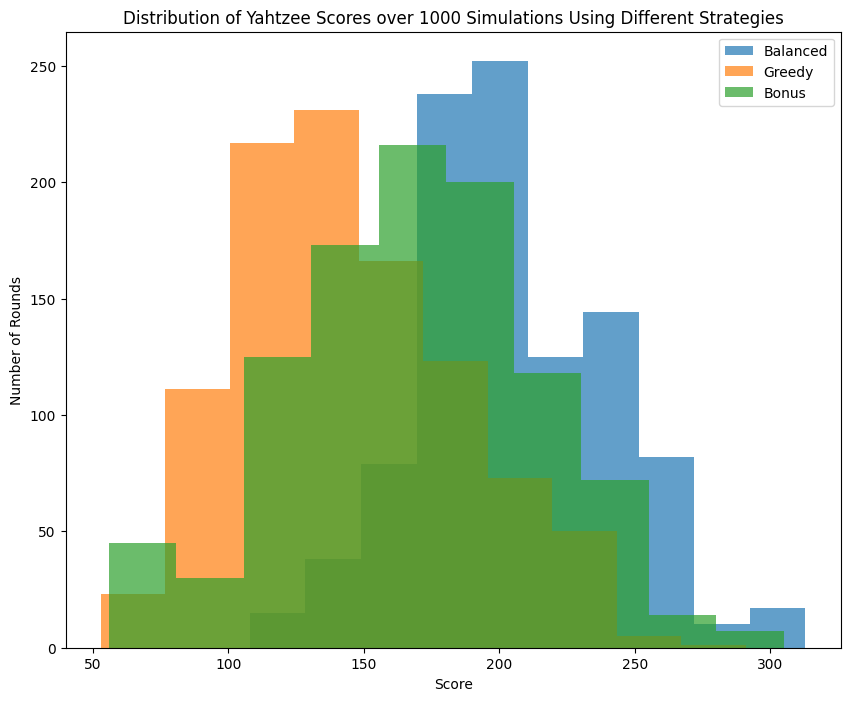

In [324]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
plt.hist(scores_optimal, label = "Balanced", alpha = .7)
plt.hist(scores_greedy, label = "Greedy", alpha = .7)
plt.hist(scores_bonus, label = "Bonus", alpha = .7)

plt.title("Distribution of Yahtzee Scores over 1000 Simulations Using Different Strategies")
plt.xlabel("Score")
plt.ylabel("Number of Rounds")
plt.legend()

plt.savefig('yahtzee_dists.png')
plt.show()


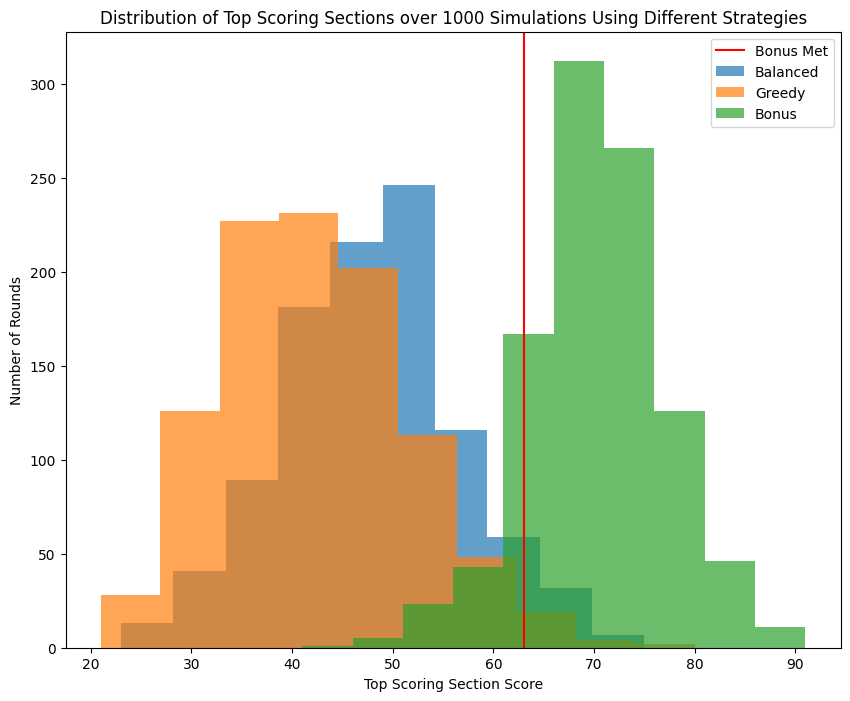

In [325]:
fig = plt.figure(figsize=(10,8))
plt.hist(top_scores_optimal, label = "Balanced", alpha = .7)
plt.hist(top_scores_greedy, label = "Greedy", alpha = .7)
plt.hist(top_scores_bonus, label = "Bonus", alpha = .7)
plt.axvline(x= 63, color= 'red',label="Bonus Met")

plt.title("Distribution of Top Scoring Sections over 1000 Simulations Using Different Strategies")
plt.xlabel("Top Scoring Section Score")
plt.ylabel("Number of Rounds")
plt.legend()

plt.savefig('yahtzee_top_scores.png')
plt.show()